In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Dataset path
dataset_slug = 'adl-project-deep-armocromia'
local_dataset_path = f'/kaggle/input/{dataset_slug}/release'

print(f"Dataset path: {local_dataset_path}")

Using device: cuda
Dataset path: /kaggle/input/adl-project-deep-armocromia/release


Loading RGB-M (Masked) dataset...

Train dataset size: 4008
Test dataset size: 912
Train class distribution:
  Autumn    : 1046
  Spring    :  978
  Summer    :  943
  Winter    : 1041
Test class distribution:
  Autumn    :  259
  Spring    :  203
  Summer    :  186
  Winter    :  264
Train DataLoader: 126 batches of 32
Test DataLoader: 29 batches of 32
Visualizing augmented training samples (Paper's augmentation only)...


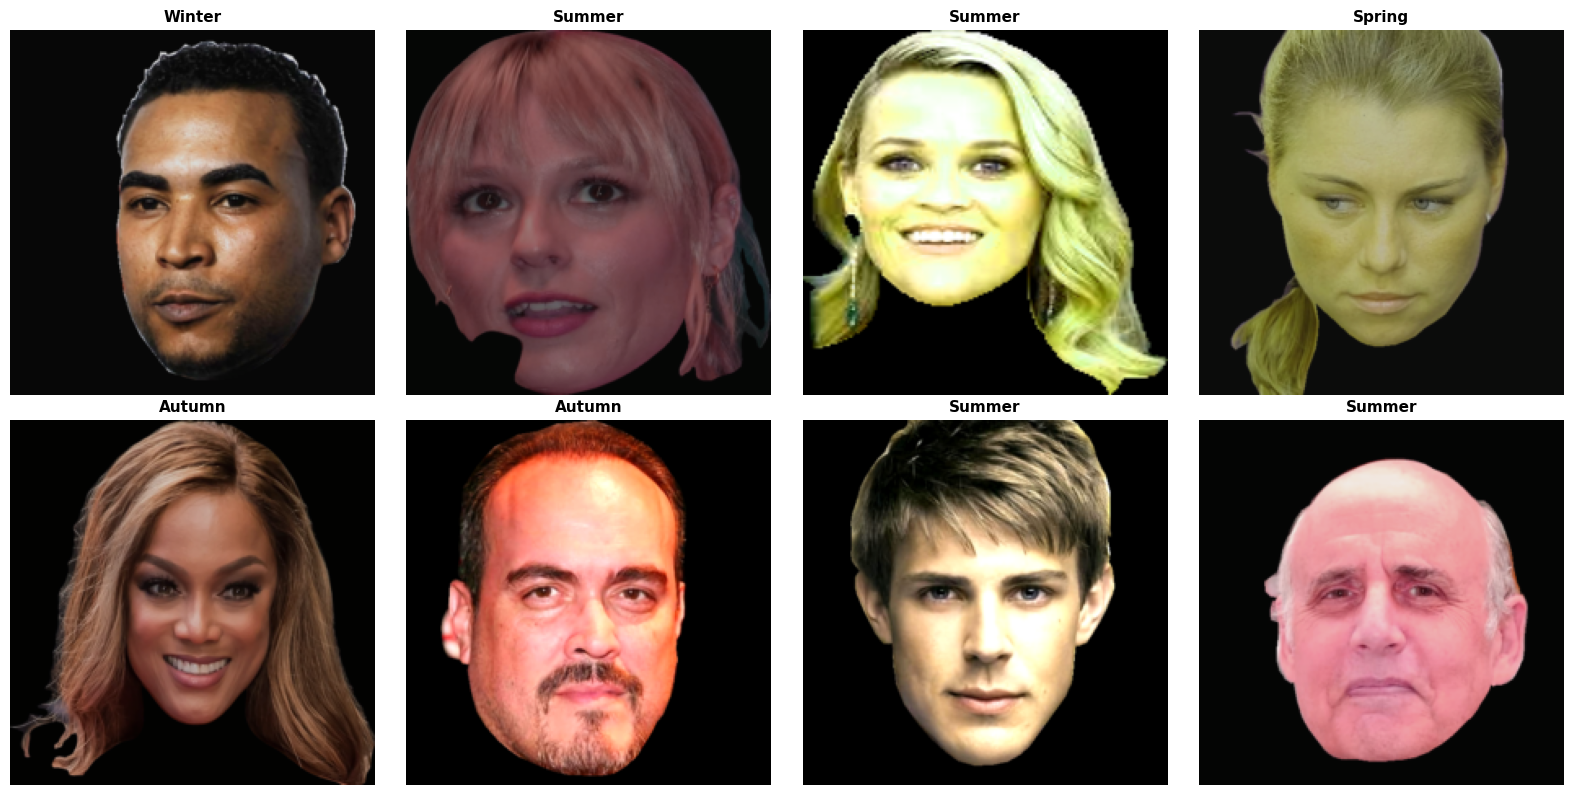

Data loading complete! (Paper's exact augmentation only)
Augmentations used (from paper):
  1. Horizontal flip (50%)
  2. ColorJitter (brightness=0.4, contrast=0.2, saturation=0.2, hue=0.1)
  3. Resize to 224×224
  4. Normalize with ImageNet stats


In [3]:
class SeasonalColorDataset(Dataset):
    """
    Custom Dataset for Seasonal Color Analysis using RGB-M (Masked Images)
    Using exact augmentations from Deep Armocromia paper
    """
    def __init__(self, base_path, partition='train', transform=None):
        self.base_path = base_path
        self.partition = partition
        self.transform = transform
        
        # Label mapping
        self.season_to_idx = {
            'autunno': 0,    # Autumn
            'estate': 1,     # Summer
            'inverno': 2,    # Winter
            'primavera': 3   # Spring
        }
        
        self.idx_to_season = {
            0: 'Autumn',
            1: 'Summer',
            2: 'Winter',
            3: 'Spring'
        }
        
        self.image_paths = []
        self.labels = []
        self._load_dataset()
    
    def _load_dataset(self):
        """Load all image paths and labels from RGB-M (Masked) folder"""
        folder_path = os.path.join(self.base_path, 'RGB-M', self.partition)
        
        if not os.path.exists(folder_path):
            print(f"Error: {folder_path} not found!")
            return
        
        for season in self.season_to_idx.keys():
            season_path = os.path.join(folder_path, season)
            
            if not os.path.exists(season_path):
                continue
            
            for sub_class in os.listdir(season_path):
                sub_class_path = os.path.join(season_path, sub_class)
                
                if not os.path.isdir(sub_class_path):
                    continue
                
                for img_file in os.listdir(sub_class_path):
                    if img_file.lower().endswith(('.jpg', '.png', '.jpeg')):
                        img_path = os.path.join(sub_class_path, img_file)
                        self.image_paths.append(img_path)
                        self.labels.append(self.season_to_idx[season])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = Image.new('RGB', (224, 224))
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def get_class_distribution(self):
        label_counts = Counter(self.labels)
        distribution = {}
        for idx, count in label_counts.items():
            distribution[self.idx_to_season[idx]] = count
        return distribution


# Create datasets
print("Loading RGB-M (Masked) dataset...")

# Data Augumentation (from research paper)
train_transforms = transforms.Compose([
    # Augmentation 1: Horizontal flip (50% probability)
    transforms.RandomHorizontalFlip(p=0.5),
    # Augmentation 2: Color jittering ONLY (paper's exact values)
    transforms.ColorJitter(brightness=0.4, contrast=0.2, saturation=0.2, hue=0.1),
    # Preprocessing: Resize
    transforms.Resize((224, 224)),
    # Convert to tensor
    transforms.ToTensor(),
    # Normalize with ImageNet stats
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Validation/test: No augmentation, just normalization
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = SeasonalColorDataset(
    base_path=local_dataset_path,
    partition='train',
    transform=train_transforms
)

test_dataset = SeasonalColorDataset(
    base_path=local_dataset_path,
    partition='test',
    transform=val_test_transforms
)

print(f"\nTrain dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

if len(train_dataset) == 0:
    print("ERROR: No images loaded!")
else:
    print("Train class distribution:")
    for season, count in sorted(train_dataset.get_class_distribution().items()):
        print(f"  {season:10s}: {count:4d}")

    print("Test class distribution:")
    for season, count in sorted(test_dataset.get_class_distribution().items()):
        print(f"  {season:10s}: {count:4d}")

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train DataLoader: {len(train_loader)} batches of {batch_size}")
print(f"Test DataLoader: {len(test_loader)} batches of {batch_size}")

# Visualize samples with MINIMAL augmentation
if len(train_dataset) > 0:
    print("Visualizing augmented training samples (Paper's augmentation only)...")
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    def denormalize(tensor):
        """Denormalize tensor for visualization"""
        inv_normalize = transforms.Compose([
            transforms.Normalize(
                mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                std=[1/0.229, 1/0.224, 1/0.225]
            )
        ])
        return inv_normalize(tensor)

    # Get one batch
    batch_images, batch_labels = next(iter(train_loader))

    season_names = {0: 'Autumn', 1: 'Summer', 2: 'Winter', 3: 'Spring'}

    for i in range(8):
        img = denormalize(batch_images[i])
        img_np = img.permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)
        
        label_idx = batch_labels[i].item()
        season = season_names[label_idx]
        
        axes[i].imshow(img_np)
        axes[i].set_title(f'{season}', fontsize=11, fontweight='bold')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    print("Data loading complete! (Paper's exact augmentation only)")
    print("Augmentations used (from paper):")
    print("  1. Horizontal flip (50%)")
    print("  2. ColorJitter (brightness=0.4, contrast=0.2, saturation=0.2, hue=0.1)")
    print("  3. Resize to 224×224")
    print("  4. Normalize with ImageNet stats")


In [4]:
from torchvision import models

print("Loading ResNet-34 model...")

# Load pre-trained ResNet-34
model = models.resnet34(pretrained=True)

# Replace final layer for 4-class classification
model.fc = nn.Linear(model.fc.in_features, 4)

# Move to device
model = model.to(device)

print("ResNet-34 loaded successfully!")
print(f"Model: {type(model).__name__}")
print(f"Pre-trained: ImageNet")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Loading ResNet-34 model...


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 208MB/s]


ResNet-34 loaded successfully!
Model: ResNet
Pre-trained: ImageNet
Total parameters: 21,286,724
Trainable parameters: 21,286,724


In [5]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.1,
    patience=5,
    verbose=True
)

print("Loss function: CrossEntropyLoss")
print("Optimizer: Adam (lr=1e-3, weight_decay=1e-5)")
print("Scheduler: ReduceLROnPlateau")

# Training functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    
    for batch_images, batch_labels in progress_bar:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        # Forward pass
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Metrics
        total_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        total_correct += (predictions == batch_labels).sum().item()
        total_samples += batch_labels.size(0)
        
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / total_samples
    
    return avg_loss, avg_accuracy

def validate(model, test_loader, criterion, device):
    """Validate on test set and return Top-1 and Top-2 accuracy"""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_correct_top2 = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc='Validating', leave=False)
        
        for batch_images, batch_labels in progress_bar:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            
            # Forward pass
            outputs = model(batch_images)
            loss = criterion(outputs, batch_labels)
            
            # Get probabilities
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            
            # Top-1
            _, predictions = torch.max(outputs, 1)
            total_correct += (predictions == batch_labels).sum().item()
            all_preds.extend(predictions.cpu().numpy())
            
            # Top-2
            _, top2_preds = torch.topk(outputs, 2, dim=1)
            for i, top2 in enumerate(top2_preds):
                if batch_labels[i] in top2:
                    total_correct_top2 += 1
            
            total_loss += loss.item()
            total_samples += batch_labels.size(0)
            all_labels.extend(batch_labels.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    avg_accuracy_top1 = total_correct / total_samples
    avg_accuracy_top2 = total_correct_top2 / total_samples
    
    return avg_loss, avg_accuracy_top1, avg_accuracy_top2, all_preds, all_labels, np.concatenate(all_probs)

print("Training functions defined!")

Loss function: CrossEntropyLoss
Optimizer: Adam (lr=1e-3, weight_decay=1e-5)
Scheduler: ReduceLROnPlateau
Training functions defined!


TRAINING: ResNet-34 on RGB-M Masked Images + Top-2 Predictions

Epoch [1/50]


Train Loss: 1.3426 | Train Acc: 0.3920
Val Loss:   2.0247 | Val Acc (Top-1): 0.3607 | Val Acc (Top-2): 0.6535
Best model saved! Top-1: 0.3607, Top-2: 0.6535

Epoch [2/50]


Train Loss: 1.2475 | Train Acc: 0.4149
Val Loss:   1.1317 | Val Acc (Top-1): 0.5088 | Val Acc (Top-2): 0.8070
Best model saved! Top-1: 0.5088, Top-2: 0.8070

Epoch [3/50]


Train Loss: 1.2088 | Train Acc: 0.4501
Val Loss:   1.2032 | Val Acc (Top-1): 0.4836 | Val Acc (Top-2): 0.7840

Epoch [4/50]


Train Loss: 1.2074 | Train Acc: 0.4521
Val Loss:   1.1600 | Val Acc (Top-1): 0.4781 | Val Acc (Top-2): 0.7599

Epoch [5/50]


Train Loss: 1.1853 | Train Acc: 0.4676
Val Loss:   1.4656 | Val Acc (Top-1): 0.4123 | Val Acc (Top-2): 0.7149

Epoch [6/50]


Train Loss: 1.1719 | Train Acc: 0.4648
Val Loss:   1.3390 | Val Acc (Top-1): 0.3893 | Val Acc (Top-2): 0.7039

Epoch [7/50]


Train Loss: 1.1728 | Train Acc: 0.4706
Val Loss:   1.1495 | Val Acc (Top-1): 0.4890 | Val Acc (Top-2): 0.7939

Epoch [8/50]


Train Loss: 1.1625 | Train Acc: 0.4810
Val Loss:   1.2216 | Val Acc (Top-1): 0.4134 | Val Acc (Top-2): 0.7083

Epoch [9/50]


Train Loss: 1.1077 | Train Acc: 0.5035
Val Loss:   1.0729 | Val Acc (Top-1): 0.5175 | Val Acc (Top-2): 0.8125
Best model saved! Top-1: 0.5175, Top-2: 0.8125

Epoch [10/50]


Train Loss: 1.1011 | Train Acc: 0.5070
Val Loss:   1.0639 | Val Acc (Top-1): 0.5373 | Val Acc (Top-2): 0.8136
Best model saved! Top-1: 0.5373, Top-2: 0.8136

Epoch [11/50]


Train Loss: 1.0828 | Train Acc: 0.5142
Val Loss:   1.0622 | Val Acc (Top-1): 0.5252 | Val Acc (Top-2): 0.8180

Epoch [12/50]


Train Loss: 1.0715 | Train Acc: 0.5250
Val Loss:   1.0792 | Val Acc (Top-1): 0.5263 | Val Acc (Top-2): 0.8224

Epoch [13/50]


Train Loss: 1.0486 | Train Acc: 0.5259
Val Loss:   1.0543 | Val Acc (Top-1): 0.5296 | Val Acc (Top-2): 0.8355

Epoch [14/50]


Train Loss: 1.0326 | Train Acc: 0.5357
Val Loss:   1.0646 | Val Acc (Top-1): 0.5329 | Val Acc (Top-2): 0.8180

Epoch [15/50]


Train Loss: 1.0194 | Train Acc: 0.5427
Val Loss:   1.1145 | Val Acc (Top-1): 0.4934 | Val Acc (Top-2): 0.7917

Epoch [16/50]


Train Loss: 1.0044 | Train Acc: 0.5504
Val Loss:   1.0580 | Val Acc (Top-1): 0.5219 | Val Acc (Top-2): 0.8246

Epoch [17/50]


Train Loss: 0.9801 | Train Acc: 0.5599
Val Loss:   1.0428 | Val Acc (Top-1): 0.5252 | Val Acc (Top-2): 0.8344

Epoch [18/50]


Train Loss: 0.9755 | Train Acc: 0.5659
Val Loss:   1.0323 | Val Acc (Top-1): 0.5329 | Val Acc (Top-2): 0.8399
Early stopping at epoch 18
Training Complete!
Best Top-1 Accuracy: 0.5373 (53.7%)
Best Top-2 Accuracy: 0.8136 (81.4%)


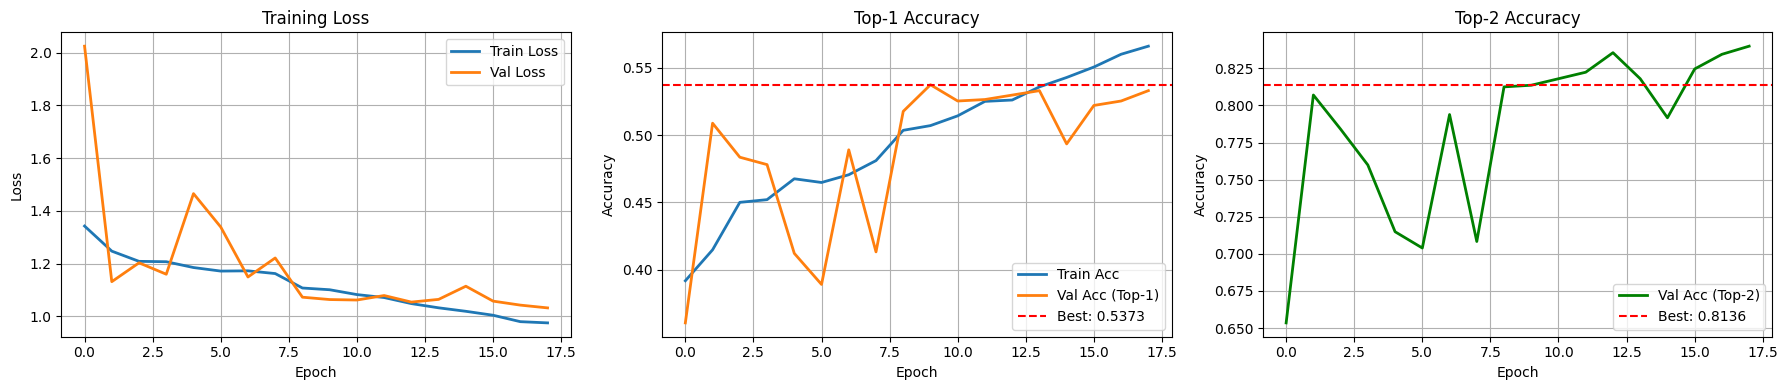

Training curves displayed!


In [6]:
print("TRAINING: ResNet-34 on RGB-M Masked Images + Top-2 Predictions")

num_epochs = 50
best_accuracy = 0
best_accuracy_top2 = 0
patience_counter = 0
max_patience = 8

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc_top1': [],
    'val_acc_top2': []
}

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    # Validate
    val_loss, val_acc_top1, val_acc_top2, _, _, _ = validate(model, test_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc_top1'].append(val_acc_top1)
    history['val_acc_top2'].append(val_acc_top2)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc (Top-1): {val_acc_top1:.4f} | Val Acc (Top-2): {val_acc_top2:.4f}")
    
    # Learning rate scheduler step
    scheduler.step(val_acc_top1)
    
    # Save best model (based on Top-1)
    if val_acc_top1 > best_accuracy:
        best_accuracy = val_acc_top1
        best_accuracy_top2 = val_acc_top2
        patience_counter = 0
        torch.save(model.state_dict(), '/kaggle/working/best_model_resnet34_rgbm.pth')
        print(f"Best model saved! Top-1: {val_acc_top1:.4f}, Top-2: {val_acc_top2:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= max_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

print(f"Training Complete!")
print(f"Best Top-1 Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.1f}%)")
print(f"Best Top-2 Accuracy: {best_accuracy_top2:.4f} ({best_accuracy_top2*100:.1f}%)")

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True)

# Top-1 Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc_top1'], label='Val Acc (Top-1)', linewidth=2)
axes[1].axhline(y=best_accuracy, color='r', linestyle='--', label=f'Best: {best_accuracy:.4f}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Top-1 Accuracy')
axes[1].legend()
axes[1].grid(True)

# Top-2 Accuracy
axes[2].plot(history['val_acc_top2'], label='Val Acc (Top-2)', linewidth=2, color='green')
axes[2].axhline(y=best_accuracy_top2, color='r', linestyle='--', label=f'Best: {best_accuracy_top2:.4f}')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Top-2 Accuracy')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

print("Training curves displayed!")

FINAL EVALUATION - Top-2 Predictions for Color Palette Generation
Evaluating on test set...


Final Test Accuracy (Top-1): 0.5373 (53.7%)
Final Test Accuracy (Top-2): 0.8136 (81.4%)
Final Test Loss: 1.0639

Per-Class Performance (Top-1):
Autumn    : 145/259 correct = 0.5598 (56.0%)
Summer    :  92/186 correct = 0.4946 (49.5%)
Winter    : 180/264 correct = 0.6818 (68.2%)
Spring    :  73/203 correct = 0.3596 (36.0%)

Top-2 Predictions Analysis (For Color Palette Generation):

Top-2 Accuracy: 742/912 = 0.8136 (81.4%)

Sample Top-2 Predictions (First 10 test samples):
Right True: Autumn   | Pred: Autumn   (51.09%) OR Winter   (39.25%)
Right True: Autumn   | Pred: Autumn   (49.03%) OR Spring   (22.08%)
Right True: Autumn   | Pred: Autumn   (52.28%) OR Spring   (28.39%)
Wrong True: Autumn   | Pred: Summer   (36.87%) OR Spring   (25.68%)
Right True: Autumn   | Pred: Autumn   (60.55%) OR Spring   (19.77%)
Right True: Autumn   | Pred: Autumn   (42.03%) OR Spring   (24.39%)
Right True: Autumn   | Pred: Autumn   (53.29%) OR Winter   (23.28%)
Right True: Autumn   | Pred: Spring   (40.92%) 

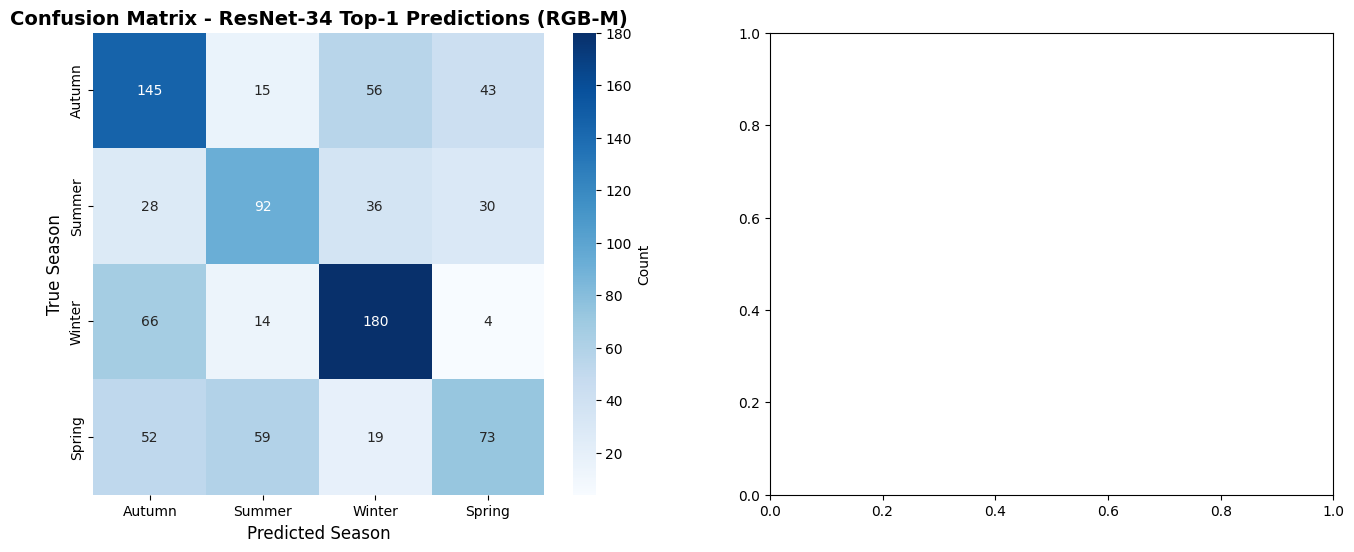

In [7]:
print("FINAL EVALUATION - Top-2 Predictions for Color Palette Generation")

# Load best model
model.load_state_dict(torch.load('/kaggle/working/best_model_resnet34_rgbm.pth'))
model.eval()

# Get predictions on test set
print("Evaluating on test set...")
test_loss, test_acc_top1, test_acc_top2, all_preds, all_labels, all_probs = validate(model, test_loader, criterion, device)

print(f"Final Test Accuracy (Top-1): {test_acc_top1:.4f} ({test_acc_top1*100:.1f}%)")
print(f"Final Test Accuracy (Top-2): {test_acc_top2:.4f} ({test_acc_top2*100:.1f}%)")
print(f"Final Test Loss: {test_loss:.4f}")

# Confusion Matrix for Top-1
class_names = ['Autumn', 'Summer', 'Winter', 'Spring']
cm = confusion_matrix(all_labels, all_preds)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top-1 Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, ax=axes[0])
axes[0].set_title('Confusion Matrix - ResNet-34 Top-1 Predictions (RGB-M)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Season', fontsize=12)
axes[0].set_xlabel('Predicted Season', fontsize=12)

# Per-class accuracy
print("\n" + "="*70)
print("Per-Class Performance (Top-1):")
print("="*70)
per_class_acc = {}
for i, season in enumerate(class_names):
    correct = cm[i, i]
    total = cm[i].sum()
    accuracy = correct / total if total > 0 else 0
    per_class_acc[season] = accuracy
    print(f"{season:10s}: {correct:3d}/{total:3d} correct = {accuracy:.4f} ({accuracy*100:.1f}%)")

# Top-2 Analysis
print("\n" + "="*70)
print("Top-2 Predictions Analysis (For Color Palette Generation):")
print("="*70)

model.eval()
top2_predictions = []
top2_confidences = []

with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        batch_images = batch_images.to(device)
        outputs = model(batch_images)
        probs = torch.softmax(outputs, dim=1)
        
        # Get top-2 predictions and confidences
        top2_probs, top2_indices = torch.topk(probs, 2, dim=1)
        
        for i in range(len(batch_labels)):
            pred1 = top2_indices[i][0].item()
            pred2 = top2_indices[i][1].item()
            conf1 = top2_probs[i][0].item()
            conf2 = top2_probs[i][1].item()
            
            top2_predictions.append((pred1, pred2))
            top2_confidences.append((conf1, conf2))

# Analyze top-2
correct_top2_count = 0
for i, (pred1, pred2) in enumerate(top2_predictions):
    if all_labels[i] in [pred1, pred2]:
        correct_top2_count += 1

print(f"\nTop-2 Accuracy: {correct_top2_count}/{len(top2_predictions)} = {correct_top2_count/len(top2_predictions):.4f} ({correct_top2_count/len(top2_predictions)*100:.1f}%)")

# Show some examples
print("\n" + "="*70)
print("Sample Top-2 Predictions (First 10 test samples):")
print("="*70)
for i in range(min(10, len(top2_predictions))):
    true_label = class_names[all_labels[i]]
    pred1 = class_names[top2_predictions[i][0]]
    pred2 = class_names[top2_predictions[i][1]]
    conf1 = top2_confidences[i][0]
    conf2 = top2_confidences[i][1]
    
    correct = "Right" if all_labels[i] in top2_predictions[i] else "Wrong"
    print(f"{correct} True: {true_label:8s} | Pred: {pred1:8s} ({conf1:.2%}) OR {pred2:8s} ({conf2:.2%})")

# Classification Report
print("\n" + "="*70)
print("Detailed Classification Report (Top-1):")
print("="*70)
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# Example of color palette for top-2 output
print("\n" + "="*70)
print("Example: How Top-2 Predictions Generate Color Palettes")
print("="*70)
color_palettes = {
    'Autumn': ['#CD853F', '#8B4513', '#D2B48C', '#DAA520', '#BC8F8F'],
    'Summer': ['#87CEEB', '#B0E0E6', '#ADD8E6', '#E0FFFF', '#F0FFFF'],
    'Winter': ['#000080', '#4169E1', '#0000CD', '#191970', '#1E90FF'],
    'Spring': ['#FFB6C1', '#FFC0CB', '#FFD700', '#90EE90', '#98FB98']
}

for i in range(min(3, len(top2_predictions))):
    pred1 = class_names[top2_predictions[i][0]]
    pred2 = class_names[top2_predictions[i][1]]
    conf1 = top2_confidences[i][0]
    conf2 = top2_confidences[i][1]
    
    print(f"User {i+1}:")
    print(f"  Primary: {pred1} ({conf1:.1%})")
    print(f"  Secondary: {pred2} ({conf2:.1%})")
    print(f"  Recommended colors:")
    print(f"    From {pred1}: {color_palettes[pred1]}")
    print(f"    From {pred2}: {color_palettes[pred2]}")
    print(f"  → User gets {len(color_palettes[pred1]) + len(color_palettes[pred2])} color options!")

print("Evaluation complete!")